/Users/apple/projects/DoraTest/path/to/venv/lib/python3.13/site-packages/langchain_google_community/vertex_ai_search.py:364: UserWarning: Beta features are configured but beta=False. The following beta features will be ignored:['custom_embedding_ratio']
  warnings.warn(


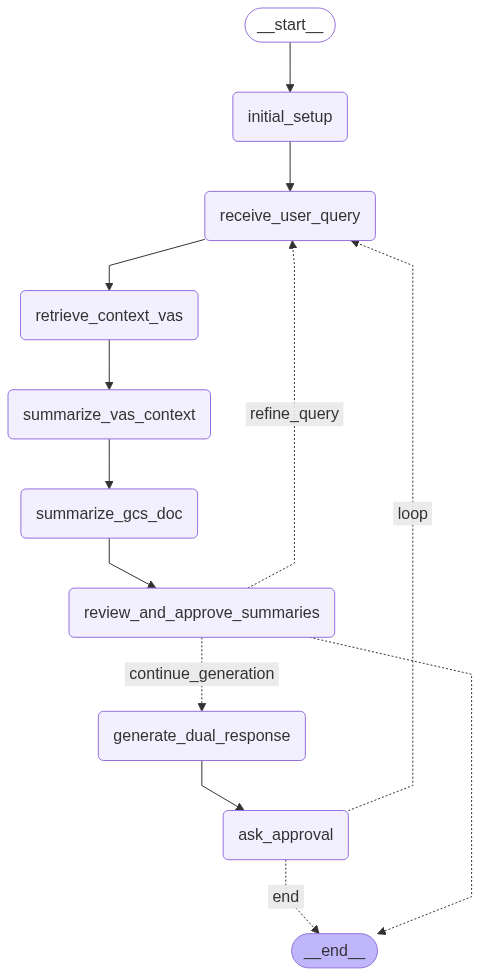

Starting LangGraph flow with GCS document processing and VAS context summarization...
---Initial Setup: Downloading and Reading GCS Document---


Ignoring wrong pointing object 95 0 (offset 0)


Successfully downloaded GCS file: gs://cloud-samples-data/generative-ai/pdf/2403.05530.pdf

--- Content of the GCS Document (first 500 chars) ---
gemini QNUZ unlocking multimodal
understanding across millions of tokens of
context
gemini teamL googleQ
in this reportL we present the latest model of the gemini familyL gemini QNU proL a highly computeMe cient
multimodal mixtureMofMexperts model capable of recalling and reasoning over ﬁneMgrained information
from millions of tokens of contextL including multiple long documents and hours of video and audioN
gemini QNU pro achieves nearMperfect recall on longMcontext retrieval tasks across modal
-----------------------------------

---Receiving User Query---
---Retrieving Context from Vertex AI Search---


/var/folders/c1/zd10q_nn0lgg5jh3pz2tpxfr0000gn/T/ipykernel_96607/2866562174.py:82: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(state["user_query"])


---Summarizing Vertex AI Search Context---


KeyboardInterrupt: 

In [1]:
from typing import TypedDict, List, Tuple, Optional
import io

from langchain_google_community import VertexAISearchRetriever
from langchain_google_vertexai import ChatVertexAI
from langgraph.graph import StateGraph, END
from google.cloud import storage
from pypdf import PdfReader
from IPython.display import Image, display

gcs_client = storage.Client()

class AgentState(TypedDict):
    user_query: str
    user_doc_uri: Optional[str]
    user_doc_content: Optional[str]
    retrieved_contexts_vas: List[str]
    summarized_vas_context: Optional[str]
    summarized_gcs_doc_content: Optional[str]
    context_approved: Optional[bool]
    llm_response_vas: Optional[str]
    llm_response_gcs: Optional[str]
    overall_response_summary: Optional[str]
    last_reply: str
    messages: List[Tuple[str, str]]

retriever = VertexAISearchRetriever(
    project_id="286507997572",
    data_store_id="doranew_1751701076413_gcs_store",
    location_id="global",
    serving_config_id="default_search",
    get_extractive_answers=True,
    max_documents=5,
    max_extractive_answer_count=1,
)

llm = ChatVertexAI(model_name="gemini-2.0-flash-lite-001")

STATE_JOINER = "\n---\n"

def initial_setup_node(state: AgentState) -> AgentState:
    print("---Initial Setup: Downloading and Reading GCS Document---")
    gcs_file_to_read_uri = "gs://cloud-samples-data/generative-ai/pdf/2403.05530.pdf"

    if not gcs_file_to_read_uri:
        print("Error: GCS file URI not defined for initial setup.")
        return state

    try:
        bucket_name = gcs_file_to_read_uri.split("//")[1].split("/")[0]
        blob_name = "/".join(gcs_file_to_read_uri.split("//")[1].split("/")[1:])
        bucket = gcs_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        pdf_bytes = blob.download_as_bytes()
        print(f"Successfully downloaded GCS file: {gcs_file_to_read_uri}")
        pdf_file = io.BytesIO(pdf_bytes)
        reader = PdfReader(pdf_file)
        doc_content = ""
        for page in reader.pages:
            doc_content += page.extract_text() + "\n"
        print("\n--- Content of the GCS Document (first 500 chars) ---")
        print(doc_content[:500])
        print("-----------------------------------\n")
        state["user_doc_uri"] = gcs_file_to_read_uri
        state["user_doc_content"] = doc_content
    except Exception as e:
        print(f"Error downloading or reading GCS document '{gcs_file_to_read_uri}': {e}")
        state["user_doc_uri"] = gcs_file_to_read_uri
        state["user_doc_content"] = f"Error reading document: {e}"
    return state

def receive_user_query_node(state: AgentState) -> AgentState:
    print("---Receiving User Query---")
    if not state.get("user_query") or state.get("context_approved") is False:
        query = input("Please enter your query: ")
        state["messages"].append(("user", query))
        return {"user_query": query, "context_approved": None}
    return state

def retrieve_context_vas_node(state: AgentState) -> AgentState:
    print("---Retrieving Context from Vertex AI Search---")
    docs = retriever.get_relevant_documents(state["user_query"])
    return {"retrieved_contexts_vas": [d.page_content for d in docs]}

def summarize_vas_context_node(state: AgentState) -> AgentState:
    print("---Summarizing Vertex AI Search Context---")
    retrieved_contexts = state["retrieved_contexts_vas"]
    if not retrieved_contexts:
        print("No Vertex AI Search contexts to summarize.")
        return {"summarized_vas_context": "No relevant context found from Vertex AI Search."}

    context_to_summarize = STATE_JOINER.join(retrieved_contexts)
    summary_prompt = (
        f"Review and summarize the following information concisely. "
        f"Focus on the key points relevant to the user's query: '{state['user_query']}'.\n\n"
        f"Information to summarize:\n{context_to_summarize}\n\n"
        "Concise Summary:"
    )
    try:
        summarized_text = llm.invoke(summary_prompt).content
        print(f"Summarized VAS Context (first 100 chars): {summarized_text[:100]}...")
        return {"summarized_vas_context": summarized_text}
    except Exception as e:
        print(f"Error summarizing Vertex AI Search context: {e}")
        return {"summarized_vas_context": f"Error summarizing context: {e}"}

def summarize_gcs_doc_node(state: AgentState) -> AgentState:
    print("---Summarizing GCS Document Content---")
    user_doc_content = state.get("user_doc_content")
    user_query = state["user_query"]

    if not user_doc_content or user_doc_content.startswith("Error reading document:"):
        print("No valid GCS document content to summarize.")
        return {"summarized_gcs_doc_content": "No valid GCS document content was available for summarization."}

    summary_prompt = (
        f"Review the following document and summarize the parts most relevant to the user's query: '{user_query}'.\n"
        f"If the document does not contain information relevant to the query, state that.\n\n"
        f"Document Content:\n{user_doc_content}\n\n"
        "Concise Summary of Document Content (relevant to query):"
    )
    try:
        summarized_text = llm.invoke(summary_prompt).content
        print(f"Summarized GCS Doc Content (first 100 chars): {summarized_text[:100]}...")
        return {"summarized_gcs_doc_content": summarized_text}
    except Exception as e:
        print(f"Error summarizing GCS document content: {e}")
        return {"summarized_gcs_doc_content": f"Error summarizing GCS document: {e}"}

def review_and_approve_summaries_node(state: AgentState) -> AgentState:
    print("\n--- Review Summaries for Approval ---")
    print("\n**Summarized Knowledge Base Context (Vertex AI Search):**")
    print(state["summarized_vas_context"])
    print("\n**Summarized User Document Content:**")
    print(state["summarized_gcs_doc_content"])
    print("-----------------------------------------\n")

    approval = input("\nDo you approve these summaries to generate the final response? (y/n): ").lower().strip()
    if approval.startswith("y"):
        print("Summaries approved.")
        return {"context_approved": True}
    else:
        print("Summaries not approved. Please refine your query.")
        return {"context_approved": False, "user_query": ""}

def generate_dual_response_node(state: AgentState) -> AgentState:
    print("---Generating Dual Response---")
    user_query = state["user_query"]
    summarized_vas_context = state.get("summarized_vas_context", "No summarized knowledge base context available.")
    user_doc_content = state.get("user_doc_content", "No GCS document content available.")
    summarized_gcs_doc_content = state.get("summarized_gcs_doc_content", "No summarized GCS document content available.")

    vas_prompt = (
        f"Based on the following summarized knowledge base context, answer the user's query.\n"
        f"If the answer is not in the context, state that you cannot find it.\n\n"
        f"User query: {user_query}\n\n"
        f"Summarized Knowledge Base Context:\n{summarized_vas_context}\n\n"
        "Response (from knowledge base):"
    )
    llm_response_vas = llm.invoke(vas_prompt).content
    print(f"Response from VAS: {llm_response_vas[:100]}...")

    gcs_prompt = (
        f"Based on the following document content, answer the user's query.\n"
        f"If the answer is not in the document, state that the document does not contain that information.\n\n"
        f"User query: {user_query}\n\n"
        f"User Document Content:\n{user_doc_content}\n\n"
        "Response (from uploaded document):"
    )
    llm_response_gcs = llm.invoke(gcs_prompt).content
    print(f"Response from GCS Doc: {llm_response_gcs[:100]}...")

    overall_summary_prompt = (
        f"Summarize the following two responses to a user's query: '{user_query}'.\n"
        f"Response from Knowledge Base:\n{llm_response_vas}\n\n"
        f"Response from User Document:\n{llm_response_gcs}\n\n"
        "Overall concise summary of the combined answer:"
    )
    overall_response_summary = llm.invoke(overall_summary_prompt).content
    print(f"Overall Summary: {overall_response_summary[:100]}...")

    combined_reply = (
        f"summary - {overall_response_summary}\n"
        f"from vas - {llm_response_vas}\n"
        f"from gcs = {llm_response_gcs}"
    )

    return {
        "llm_response_vas": llm_response_vas,
        "llm_response_gcs": llm_response_gcs,
        "overall_response_summary": overall_response_summary,
        "last_reply": combined_reply
    }

def node_ask_approval(state: AgentState) -> AgentState:
    print("\n--- AI Combined Response ---")
    print(state["last_reply"])
    print("--------------------------\n")
    state["messages"].append(("assistant", state["last_reply"]))
    approval = input("\nAre you satisfied with this response? (y/n): ").lower().strip()
    if approval.startswith("y"):
        state["messages"].append(("system", "Approved"))
        return state
    else:
        new_query = input("Please refine your query or clarify what you're looking for: ")
        return {
            "user_query": new_query,
            "last_reply": "",
            "llm_response_vas": None,
            "llm_response_gcs": None,
            "overall_response_summary": None,
            "summarized_vas_context": None,
            "summarized_gcs_doc_content": None,
            "context_approved": None
        }

workflow = StateGraph(AgentState)

workflow.add_node("initial_setup", initial_setup_node)
workflow.add_node("receive_user_query", receive_user_query_node)
workflow.add_node("retrieve_context_vas", retrieve_context_vas_node)
workflow.add_node("summarize_vas_context", summarize_vas_context_node)
workflow.add_node("summarize_gcs_doc", summarize_gcs_doc_node)
workflow.add_node("review_and_approve_summaries", review_and_approve_summaries_node)
workflow.add_node("generate_dual_response", generate_dual_response_node)
workflow.add_node("ask_approval", node_ask_approval)

workflow.set_entry_point("initial_setup")

workflow.add_edge("initial_setup", "receive_user_query")
workflow.add_edge("receive_user_query", "retrieve_context_vas")
workflow.add_edge("retrieve_context_vas", "summarize_vas_context")
workflow.add_edge("summarize_vas_context", "summarize_gcs_doc")
workflow.add_edge("summarize_gcs_doc", "review_and_approve_summaries")

workflow.add_conditional_edges(
    "review_and_approve_summaries",
    lambda state: "continue_generation" if state.get("context_approved") else "refine_query",
    {
        "continue_generation": "generate_dual_response",
        "refine_query": "receive_user_query"
    }
)

workflow.add_edge("generate_dual_response", "ask_approval")

workflow.add_conditional_edges(
    "ask_approval",
    lambda state: "loop" if state.get("user_query") else "end",
    {"loop": "receive_user_query", "end": END}
)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

if __name__ == "__main__":
    initial_state = AgentState(
        user_query="",
        user_doc_uri=None,
        user_doc_content=None,
        retrieved_contexts_vas=[],
        summarized_vas_context=None,
        summarized_gcs_doc_content=None,
        context_approved=None,
        llm_response_vas=None,
        llm_response_gcs=None,
        overall_response_summary=None,
        last_reply="",
        messages=[]
    )

    print("Starting LangGraph flow with GCS document processing and VAS context summarization...")
    current_state = initial_state
    try:
        final_state = app.invoke(current_state)

        print("\n--- Final Conversation History ---")
        for role, content in final_state["messages"]:
            print(f"  {role.capitalize()}: {content}")
        print("----------------------------------")

        if final_state["messages"] and final_state["messages"][-1][0] == "system" and final_state["messages"][-1][1] == "Approved":
            print("\nUser approved. Conversation ended.")
        else:
            print("\nConversation ended (user likely did not approve the final response or an error occurred).")

    except Exception as e:
        print(f"\nAn error occurred during graph execution: {e}")


/Users/apple/projects/DoraTest/path/to/venv/lib/python3.13/site-packages/langchain_google_community/vertex_ai_search.py:364: UserWarning: Beta features are configured but beta=False. The following beta features will be ignored:['custom_embedding_ratio']
  warnings.warn(


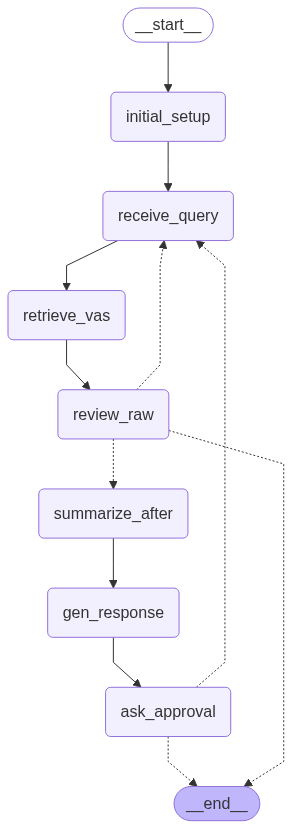

🚀 Starting workflow...
✅ PDF downloaded and read.

--- RAW VAS Contexts ---
o When you are bullish on a stock you can either buy the stock in spot, buy its futures, or buy a call option o When you are bearish on a stock you can either sell the stock in the spot (although on a intraday basis), short futures, or short a call option o The calculation of the intrinsic value for call option is standard, it does not change based on whether you are an option buyer/ seller o However the intrinsic value calculation changes for a &#39;Put&#39; option o The net P&amp;L calculation 
---

--- RAW GCS Document (first 1000 chars) ---
 FINANCE
College of Business Administration
T H E U N I V E R S I T Y O F  T E X A S  A T  E L  P A S O

What is Finance?
• "Finance" is a broad term that describes 
two related activities: the study of how 
money is managed and the actual process 
of acquiring needed funds. 
• Because individuals, businesses and 
government entities all need funding to 
operate, the fie

In [2]:
from typing import TypedDict, List, Tuple, Optional
import io
from langchain_google_community import VertexAISearchRetriever
from langchain_google_vertexai import ChatVertexAI
from langgraph.graph import StateGraph, END
from google.cloud import storage
from pypdf import PdfReader
from IPython.display import Image, display

gcs_client = storage.Client()

retriever = VertexAISearchRetriever(
    project_id="286507997572",
    data_store_id="doranew_1751701076413_gcs_store",
    location_id="global",
    serving_config_id="default_search",
    get_extractive_answers=True,
    max_documents=5,
    max_extractive_answer_count=1,
)

llm = ChatVertexAI(model_name="gemini-2.0-flash-lite-001")
STATE_JOINER = "\n---\n"

class AgentState(TypedDict):
    user_query: str
    user_doc_uri: Optional[str]
    user_doc_content: Optional[str]
    retrieved_contexts_vas: List[str]
    summarized_vas_context: Optional[str]
    summarized_gcs_doc_content: Optional[str]
    context_approved: Optional[bool]
    llm_response_vas: Optional[str]
    llm_response_gcs: Optional[str]
    overall_response_summary: Optional[str]
    last_reply: str
    messages: List[Tuple[str, str]]

def initial_setup_node(state: AgentState) -> AgentState:
    uri = "gs://user-docs-dora/incoming/userdoc.pdf"
    state["user_doc_uri"] = uri
    try:
        bucket, blob = uri.split("//")[1].split("/", 1)
        pdf_bytes = gcs_client.bucket(bucket).blob(blob).download_as_bytes()
        content = "".join(page.extract_text() + "\n" for page in PdfReader(io.BytesIO(pdf_bytes)).pages)
        state["user_doc_content"] = content
        print("✅ PDF downloaded and read.")
    except Exception as e:
        state["user_doc_content"] = f"Error reading doc: {e}"
        print("❌", state["user_doc_content"])
    return state

def receive_user_query_node(state: AgentState) -> AgentState:
    if not state["user_query"] or state.get("context_approved") is False:
        q = input("Enter your query: ").strip()
        state["messages"].append(("user", q))
        return {**state, "user_query": q, "context_approved": None}
    return state

def retrieve_context_vas_node(state: AgentState) -> AgentState:
    docs = retriever.get_relevant_documents(state["user_query"])
    return {**state, "retrieved_contexts_vas": [d.page_content for d in docs]}

def review_raw_contexts_node(state: AgentState) -> AgentState:
    print("\n--- RAW VAS Contexts ---")
    for snippet in state["retrieved_contexts_vas"]:
        print(snippet[:500], "\n---")
    doc = state["user_doc_content"] or ""
    print("\n--- RAW GCS Document (first 1000 chars) ---\n", doc[:1000])
    ok = input("Approve to summarize and generate response? (y/n): ").strip().lower().startswith("y")
    return {**state, "context_approved": ok, "user_query": state["user_query"] if ok else ""}

def summarize_after_approval_node(state: AgentState) -> AgentState:
    vas = llm.invoke(f"Summarize VAS for '{state['user_query']}':\n" + STATE_JOINER.join(state["retrieved_contexts_vas"])).content
    gcs = llm.invoke(f"Summarize GCS doc for '{state['user_query']}':\n{state['user_doc_content']}").content
    return {**state, "summarized_vas_context": vas, "summarized_gcs_doc_content": gcs}

def generate_dual_response_node(state: AgentState) -> AgentState:
    q = state["user_query"]
    vas_r = llm.invoke(f"Answer from VAS:\n{state['summarized_vas_context']}\nQ: {q}").content
    gcs_r = llm.invoke(f"Answer from doc:\n{state['summarized_gcs_doc_content']}\nQ: {q}").content
    summ = llm.invoke(f"Summarize both:\nVAS: {vas_r}\nDOC: {gcs_r}").content
    reply = f"summary - {summ}\nfrom vas - {vas_r}\nfrom gcs = {gcs_r}"
    return {
        **state,
        "llm_response_vas": vas_r,
        "llm_response_gcs": gcs_r,
        "overall_response_summary": summ,
        "last_reply": reply
    }

def node_ask_approval(state: AgentState) -> AgentState:
    print("\n--- Final Reply ---\n", state["last_reply"])
    state["messages"].append(("assistant", state["last_reply"]))
    ok = input("Approve final reply? (y/n): ").strip().lower().startswith("y")
    if ok:
        state["messages"].append(("system", "Approved"))
        return state
    new_q = input("Refine query: ").strip()
    return {
        **state,
        "user_query": new_q,
        "last_reply": "",
        "llm_response_vas": None,
        "llm_response_gcs": None,
        "overall_response_summary": None,
        "summarized_vas_context": None,
        "summarized_gcs_doc_content": None,
        "context_approved": None
    }

workflow = StateGraph(AgentState)
workflow.add_node("initial_setup", initial_setup_node)
workflow.add_node("receive_query", receive_user_query_node)
workflow.add_node("retrieve_vas", retrieve_context_vas_node)
workflow.add_node("review_raw", review_raw_contexts_node)
workflow.add_node("summarize_after", summarize_after_approval_node)
workflow.add_node("gen_response", generate_dual_response_node)
workflow.add_node("ask_approval", node_ask_approval)

workflow.set_entry_point("initial_setup")
workflow.add_edge("initial_setup", "receive_query")
workflow.add_edge("receive_query", "retrieve_vas")
workflow.add_edge("retrieve_vas", "review_raw")

workflow.add_conditional_edges(
    "review_raw",
    lambda s: "summarize_after" if s["context_approved"] else "receive_query",
    {
        "summarize_after": "summarize_after",
        "receive_query": "receive_query"
    }
)

workflow.add_edge("summarize_after", "gen_response")
workflow.add_edge("gen_response", "ask_approval")

workflow.add_conditional_edges(
    "ask_approval",
    lambda s: END if s.get("messages") and s["messages"][-1] == ("system", "Approved") else "receive_query",
    {
        "receive_query": "receive_query",
        END: END
    }
)

app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

if __name__ == "__main__":
    init: AgentState = dict(
        user_query="",
        user_doc_uri=None,
        user_doc_content=None,
        retrieved_contexts_vas=[],
        summarized_vas_context=None,
        summarized_gcs_doc_content=None,
        context_approved=None,
        llm_response_vas=None,
        llm_response_gcs=None,
        overall_response_summary=None,
        last_reply="",
        messages=[]
    )
    print("🚀 Starting workflow...")
    final = app.invoke(init)
    print("\n--- Conversation ---")
    for r, c in final["messages"]:
        print(f"{r}: {c}")
    print("✅ Done.")
